In [1]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from torchwi import Tomo2d
from torchwi.io import rsf, CFGParser
from pkrh.torchwi import param_selector, get_land_mask
from SSIM import SSIM
import time

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import csv

In [4]:
vmin, vmax = 1.5, 5.0
ax = np.arange(0, 320)

In [5]:
nx=320
ny=50
h=0.1
shotskip=2

shape = (nx,ny)
meter_to_km=0.001

In [6]:
nshot = 200
#ivel = 29000

sxs = (104 + np.arange(nshot))*h
sy = 0.
ry = 0.

In [7]:
rx = np.zeros((nshot,2),dtype=np.int32)

for ishot in range(nshot):
    rx[ishot,0] = 2 + ishot
    rx[ishot,1] = rx[ishot,0] + 100

print("nshot=%d, sy=%s, ry=%s"%(nshot,sy,ry))

nshot=200, sy=0.0, ry=0.0


In [8]:
rcv_mask = np.zeros((nshot,nx),dtype=bool)

for ishot in range(nshot):
    ir0 = rx[ishot,0]
    ir1 = rx[ishot,1]
    rcv_mask[ishot,ir0:ir1] = True

In [9]:
rcv_mask = torch.from_numpy(rcv_mask)

In [10]:
tomo = Tomo2d(nx,ny,h)
freq = 0.05
vmean = 3.0

In [11]:
alpha = 2*np.pi / (20*h) * vmean
omega = 2.*np.pi*freq - alpha * 1.0j

# Marmousi

In [12]:
ttime_obs = np.fromfile("ttime_marm_water.bin",dtype=np.float32)
ttime_obs.shape=(nshot,nx)

In [13]:
ttime_obs.shape

(200, 320)

In [14]:
pred_tomo = np.fromfile("./pred_marm00500.bin",dtype=np.float32)
pred_tomo.shape = (nx,ny)

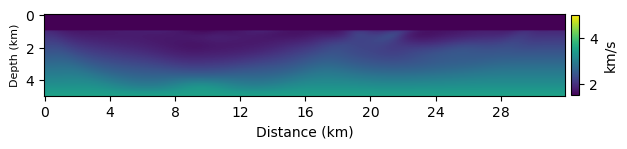

In [15]:
plt.figure(figsize=[8,3])
plt.imshow(pred_tomo.T, vmin=1.5, vmax=5.0)
plt.xticks(np.arange(0, 320, 40), np.arange(0, 32, 4))
plt.yticks(np.arange(0, 50, 20), np.arange(0, 5, 2))
plt.xlabel("Distance (km)",fontsize=10)
plt.ylabel("Depth (km)",fontsize=8)
plt.colorbar(shrink=0.35, aspect=10, pad=0.01, label="km/s")

In [16]:
pred_dl = np.fromfile("./pred_marm_sm20_00500.bin",dtype=np.float32)
pred_dl.shape = (nx,ny)

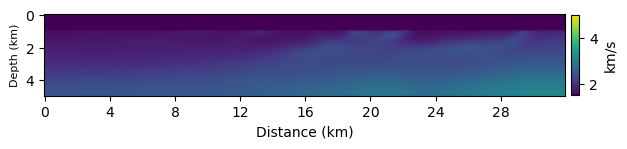

In [17]:
plt.figure(figsize=[8,3])
plt.imshow(pred_dl.T, vmin=1.5, vmax=5.0)
plt.xticks(np.arange(0, 320, 40), np.arange(0, 32, 4))
plt.yticks(np.arange(0, 50, 20), np.arange(0, 5, 2))
plt.xlabel("Distance (km)",fontsize=10)
plt.ylabel("Depth (km)",fontsize=8)
plt.colorbar(shrink=0.35, aspect=10, pad=0.01, label="km/s")

In [18]:
vinit = np.fromfile("./pred_marm.bin",dtype=np.float32)
vinit.shape = (nx,ny)

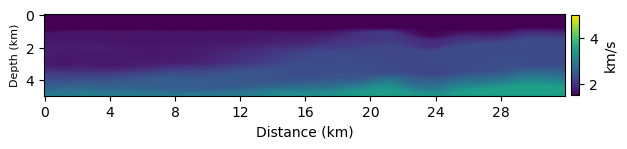

In [19]:
plt.figure(figsize=[8,3])
plt.imshow(vinit.T, vmin=1.5, vmax=5.0)
plt.xticks(np.arange(0, 320, 40), np.arange(0, 32, 4))
plt.yticks(np.arange(0, 50, 20), np.arange(0, 5, 2))
plt.xlabel("Distance (km)",fontsize=10)
plt.ylabel("Depth (km)",fontsize=8)
plt.colorbar(shrink=0.35, aspect=10, pad=0.01, label="km/s")

In [20]:
def plot_traveltime(ttime_obs, vel_tomo, vel_dl):
    
    tomo.factorize(omega, vel_tomo())
    ttime_tomo = tomo.forward(vel_tomo(), torch.from_numpy(sxs), sy, ry) * rcv_mask
    
    tomo.factorize(omega, vel_dl())
    ttime_dl = tomo.forward(vel_dl(), torch.from_numpy(sxs), sy, ry) * rcv_mask
    
    plt.figure(figsize=[12,4])
    plt.xlabel('Distance (km)', fontsize=15)
    plt.ylabel('Time (s)', fontsize=15)
    plt.plot(ax[ttime_obs[0]>0], ttime_obs[0,ttime_obs[0]>0], "r-", label="Observed")
    plt.plot(ax[ttime_tomo[0].detach().numpy()>0], ttime_tomo[0,ttime_tomo[0]>0].detach().numpy(), "b--", label="Modeled_tomo")
    plt.plot(ax[ttime_dl[0].detach().numpy()>0], ttime_dl[0,ttime_dl[0]>0].detach().numpy(), "c-.", label="Modeled_dl")
    plt.legend(loc="upper right")
    
    plt.plot(ax[ttime_obs[49]>0], ttime_obs[49,ttime_obs[49]>0], "r-", label="Observed")
    plt.plot(ax[ttime_tomo[49].detach().numpy()>0], ttime_tomo[49,ttime_tomo[49]>0].detach().numpy(), "b--", label="Modeled_tomo")
    plt.plot(ax[ttime_dl[49].detach().numpy()>0], ttime_dl[49,ttime_dl[49]>0].detach().numpy(), "c-.", label="Modeled_dl")
    
    plt.plot(ax[ttime_obs[99]>0], ttime_obs[99,ttime_obs[99]>0], "r-", label="Observed")
    plt.plot(ax[ttime_tomo[99].detach().numpy()>0], ttime_tomo[99,ttime_tomo[99]>0].detach().numpy(), "b--", label="Modeled_tomo")
    plt.plot(ax[ttime_dl[99].detach().numpy()>0], ttime_dl[99,ttime_dl[99]>0].detach().numpy(), "c-.", label="Modeled_dl")
   
    plt.plot(ax[ttime_obs[149]>0], ttime_obs[149,ttime_obs[149]>0], "r-", label="Observed")
    plt.plot(ax[ttime_tomo[149].detach().numpy()>0], ttime_tomo[149,ttime_tomo[149]>0].detach().numpy(), "b--", label="Modeled_tomo")
    plt.plot(ax[ttime_dl[149].detach().numpy()>0], ttime_dl[149,ttime_dl[149]>0].detach().numpy(), "c-.", label="Modeled_dl")
    
    plt.plot(ax[ttime_obs[199]>0], ttime_obs[199,ttime_obs[199]>0], "r-", label="Observed")
    plt.plot(ax[ttime_tomo[199].detach().numpy()>0], ttime_tomo[199,ttime_tomo[199]>0].detach().numpy(), "b--", label="Modeled_tomo")
    plt.plot(ax[ttime_dl[199].detach().numpy()>0], ttime_dl[199,ttime_dl[199]>0].detach().numpy(), "c-.", label="Modeled_dl")
    plt.xticks(np.arange(0, 320, 50), np.arange(0, 32, 5))

In [21]:
vel_tomo = param_selector('velocity',pred_tomo,vmin,vmax)

In [22]:
vel_dl = param_selector('velocity',pred_dl,vmin,vmax)

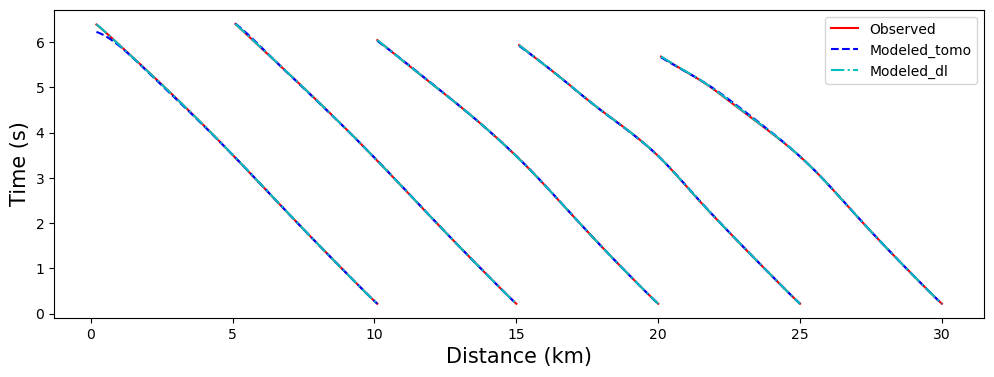

In [23]:
plot_traveltime(ttime_obs, vel_tomo,vel_dl)

In [24]:
tomo_loss = []

with open('marm_losses.csv','r',newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        tomo_loss.extend(row) 

In [25]:
tomo_norm_loss = []

with open('marm_norm_losses.csv','r',newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        tomo_norm_loss.extend(row)

In [26]:
dl_loss = []

with open('marm_sm20_losses.csv','r',newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        dl_loss.extend(row)

In [27]:
dl_norm_loss = []

with open('marm_sm20_norm_losses.csv','r',newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        dl_norm_loss.extend(row)

In [28]:
for i in range(len(tomo_loss)):
    tomo_loss[i] = float(tomo_loss[i])

In [29]:
for i in range(len(dl_loss)):
    dl_loss[i] = float(dl_loss[i])

In [30]:
for i in range(len(tomo_norm_loss)):
    tomo_norm_loss[i] = float(tomo_norm_loss[i])

In [31]:
for i in range(len(dl_norm_loss)):
    dl_norm_loss[i] = float(dl_norm_loss[i])

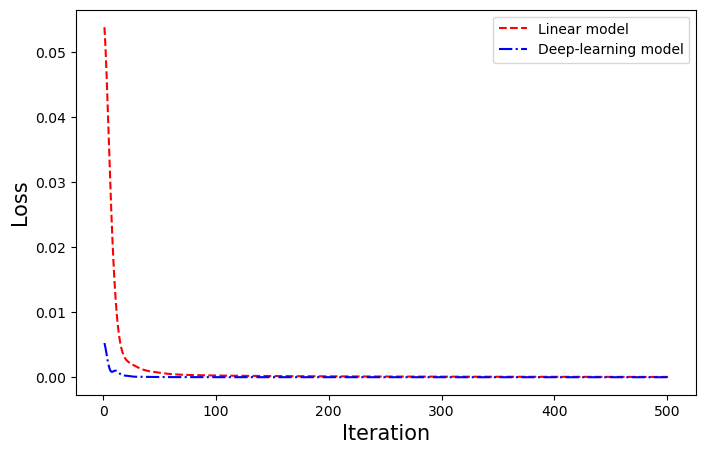

In [32]:
plt.figure(figsize=[8,5])

plt.plot(range(1,len(tomo_loss)+1), tomo_loss,'r--', label="Linear model")
plt.plot(range(1,len(dl_loss)+1),dl_loss,'b-.', label="Deep-learning model")
#plt.title('Traveltime tomography', fontsize=15)
plt.yscale("linear")
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(loc="upper right")

plt.show()

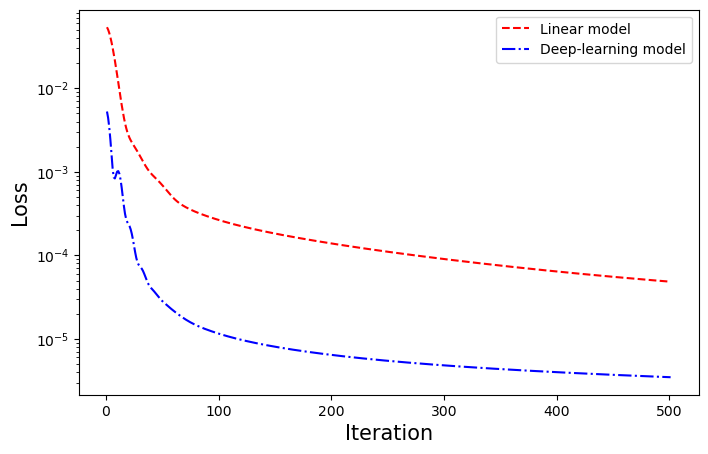

In [33]:
plt.figure(figsize=[8,5])

plt.plot(range(1,len(tomo_loss)+1), tomo_loss,'r--', label="Linear model")
plt.plot(range(1,len(dl_loss)+1),dl_loss,'b-.', label="Deep-learning model")
#plt.title('Traveltime tomography', fontsize=15)
plt.yscale("log")
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(loc="upper right")

plt.show()

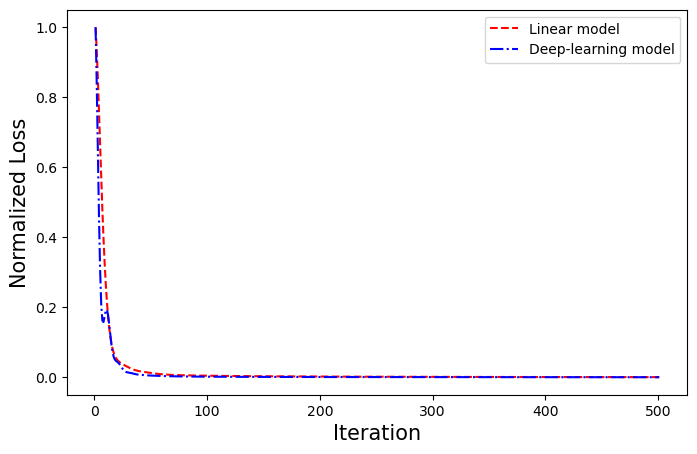

In [34]:
plt.figure(figsize=[8,5])

plt.plot(range(1,len(tomo_norm_loss)+1),tomo_norm_loss,'r--', label="Linear model")
plt.plot(range(1,len(dl_norm_loss)+1),dl_norm_loss,'b-.', label="Deep-learning model")
#plt.title('Traveltime tomography', fontsize=15)
plt.yscale("linear")
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Normalized Loss', fontsize=15)
plt.legend(loc="upper right")

plt.show()

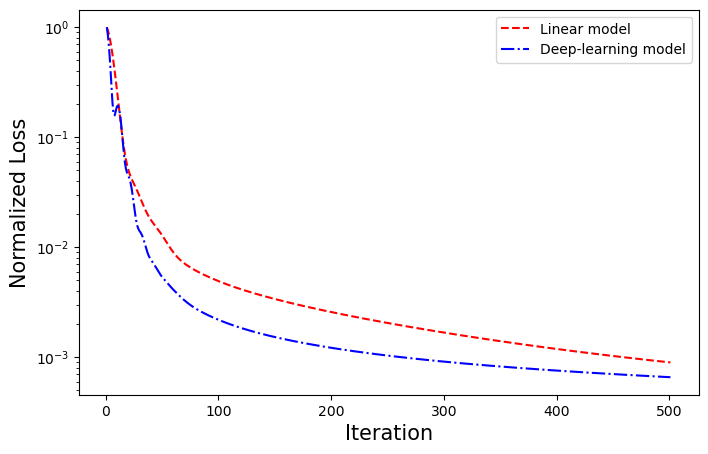

In [35]:
plt.figure(figsize=[8,5])

plt.plot(range(1,len(tomo_norm_loss)+1),tomo_norm_loss,'r--', label="Linear model")
plt.plot(range(1,len(dl_norm_loss)+1),dl_norm_loss,'b-.', label="Deep-learning model")
#plt.title('Traveltime tomography', fontsize=15)
plt.yscale("log")
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Normalized Loss', fontsize=15)
plt.legend(loc="upper right")

plt.show()

# Congo

In [36]:
ttime_obs = np.fromfile("ttime_congo.bin",dtype=np.float32)
ttime_obs.shape=(nx,nshot)

In [37]:
ttime_obs = np.transpose(ttime_obs)

In [38]:
ttime_obs.shape

(200, 320)

In [39]:
pred_tomo = np.fromfile("./pred_congo00500.bin",dtype=np.float32)
pred_tomo.shape = (nx,ny)

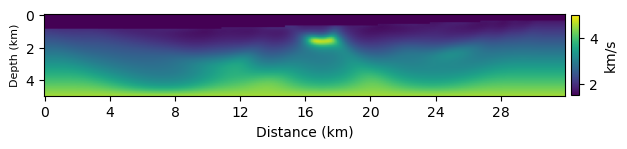

In [40]:
plt.figure(figsize=[8,3])
plt.imshow(pred_tomo.T, vmin=1.5, vmax=5.0)
plt.xticks(np.arange(0, 320, 40), np.arange(0, 32, 4))
plt.yticks(np.arange(0, 50, 20), np.arange(0, 5, 2))
plt.xlabel("Distance (km)",fontsize=10)
plt.ylabel("Depth (km)",fontsize=8)
plt.colorbar(shrink=0.35, aspect=10, pad=0.01, label="km/s")

In [41]:
pred_dl = np.fromfile("./pred_congo_sm30_00500.bin",dtype=np.float32)
pred_dl.shape = (nx,ny)

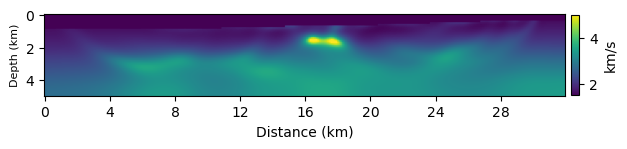

In [42]:
plt.figure(figsize=[8,3])
plt.imshow(pred_dl.T, vmin=1.5, vmax=5.0)
plt.xticks(np.arange(0, 320, 40), np.arange(0, 32, 4))
plt.yticks(np.arange(0, 50, 20), np.arange(0, 5, 2))
plt.xlabel("Distance (km)",fontsize=10)
plt.ylabel("Depth (km)",fontsize=8)
plt.colorbar(shrink=0.35, aspect=10, pad=0.01, label="km/s")

In [43]:
vinit = np.fromfile("./pred_congo.bin",dtype=np.float32)
vinit.shape = (nx,ny)

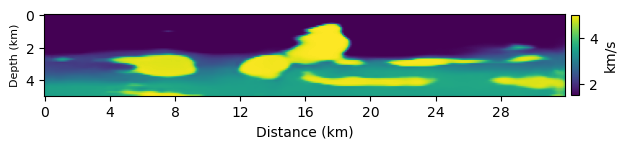

In [44]:
plt.figure(figsize=[8,3])
plt.imshow(vinit.T, vmin=1.5, vmax=5.0)
plt.xticks(np.arange(0, 320, 40), np.arange(0, 32, 4))
plt.yticks(np.arange(0, 50, 20), np.arange(0, 5, 2))
plt.xlabel("Distance (km)",fontsize=10)
plt.ylabel("Depth (km)",fontsize=8)
plt.colorbar(shrink=0.35, aspect=10, pad=0.01, label="km/s")

In [45]:
vel_tomo = param_selector('velocity',pred_tomo,vmin,vmax)

In [46]:
vel_dl = param_selector('velocity',pred_dl,vmin,vmax)

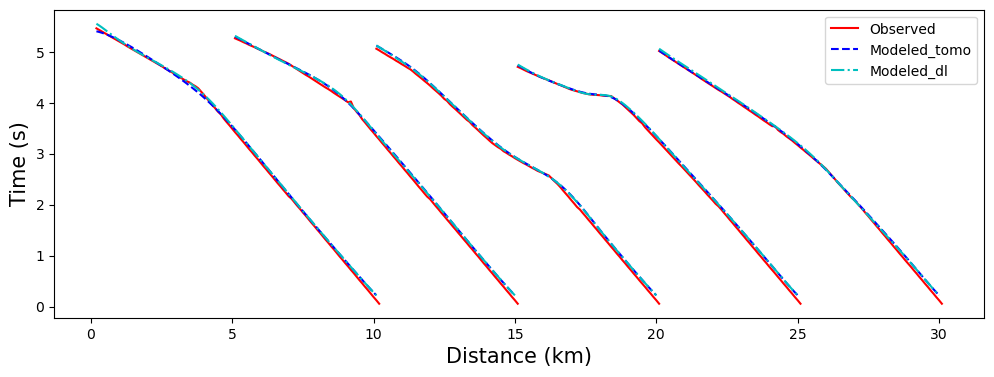

In [47]:
plot_traveltime(ttime_obs, vel_tomo,vel_dl)

In [48]:
tomo_loss = []

with open('congo_losses.csv','r',newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        tomo_loss.extend(row) 

In [49]:
tomo_norm_loss = []

with open('congo_norm_losses.csv','r',newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        tomo_norm_loss.extend(row)

In [50]:
dl_loss = []

with open('congo_sm30_losses.csv','r',newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        dl_loss.extend(row)

In [51]:
dl_norm_loss = []

with open('congo_sm30_norm_losses.csv','r',newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        dl_norm_loss.extend(row)

In [52]:
for i in range(len(tomo_loss)):
    tomo_loss[i] = float(tomo_loss[i])

In [53]:
for i in range(len(dl_loss)):
    dl_loss[i] = float(dl_loss[i])

In [54]:
for i in range(len(tomo_norm_loss)):
    tomo_norm_loss[i] = float(tomo_norm_loss[i])

In [55]:
for i in range(len(dl_norm_loss)):
    dl_norm_loss[i] = float(dl_norm_loss[i])

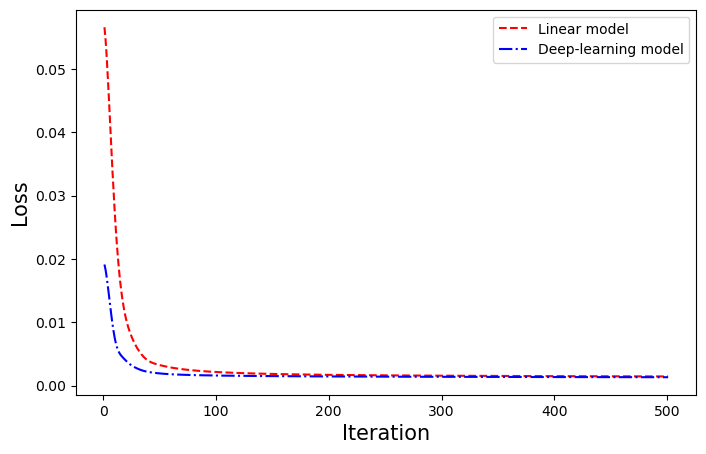

In [56]:
plt.figure(figsize=[8,5])

plt.plot(range(1,len(tomo_loss)+1), tomo_loss,'r--', label="Linear model")
plt.plot(range(1,len(dl_loss)+1),dl_loss,'b-.', label="Deep-learning model")
#plt.title('Traveltime tomography', fontsize=15)
plt.yscale("linear")
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(loc="upper right")

plt.show()

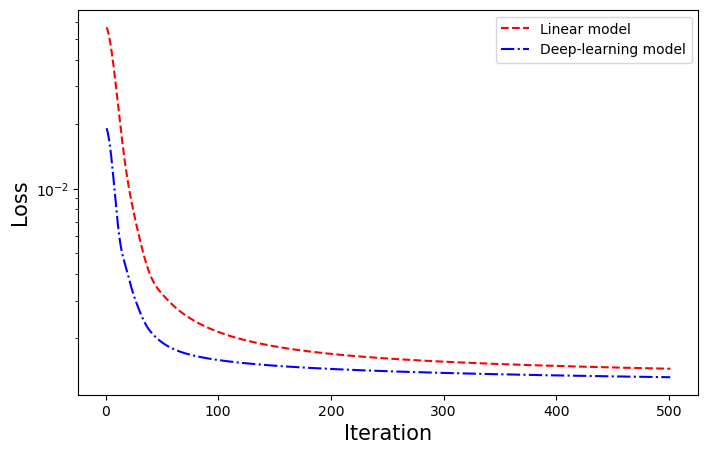

In [57]:
plt.figure(figsize=[8,5])

plt.plot(range(1,len(tomo_loss)+1), tomo_loss,'r--', label="Linear model")
plt.plot(range(1,len(dl_loss)+1),dl_loss,'b-.', label="Deep-learning model")
#plt.title('Traveltime tomography', fontsize=15)
plt.yscale("log")
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(loc="upper right")

plt.show()

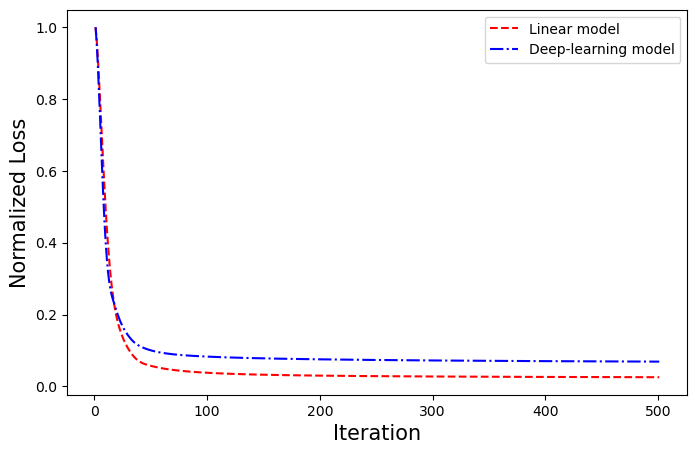

In [58]:
plt.figure(figsize=[8,5])

plt.plot(range(1,len(tomo_norm_loss)+1),tomo_norm_loss,'r--', label="Linear model")
plt.plot(range(1,len(dl_norm_loss)+1),dl_norm_loss,'b-.', label="Deep-learning model")
#plt.title('Traveltime tomography', fontsize=15)
plt.yscale("linear")
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Normalized Loss', fontsize=15)
plt.legend(loc="upper right")

plt.show()

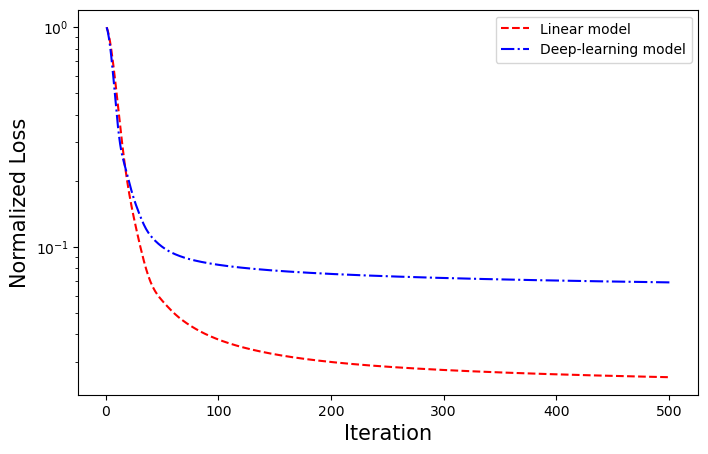

In [59]:
plt.figure(figsize=[8,5])

plt.plot(range(1,len(tomo_norm_loss)+1),tomo_norm_loss,'r--', label="Linear model")
plt.plot(range(1,len(dl_norm_loss)+1),dl_norm_loss,'b-.', label="Deep-learning model")
#plt.title('Traveltime tomography', fontsize=15)
plt.yscale("log")
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Normalized Loss', fontsize=15)
plt.legend(loc="upper right")

plt.show()

# Test data

In [60]:
tomo1_norm_loss = []

with open('test_38080_norm_losses.csv','r',newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        tomo1_norm_loss.extend(row)

In [61]:
tomo2_norm_loss = []

with open('test_38640_norm_losses.csv','r',newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        tomo2_norm_loss.extend(row)

In [62]:
tomo3_norm_loss = []

with open('test_39920_norm_losses.csv','r',newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        tomo3_norm_loss.extend(row)

In [63]:
for i in range(len(tomo1_norm_loss)):
    tomo1_norm_loss[i] = float(tomo1_norm_loss[i])

In [64]:
for i in range(len(tomo2_norm_loss)):
    tomo2_norm_loss[i] = float(tomo2_norm_loss[i])

In [65]:
for i in range(len(tomo3_norm_loss)):
    tomo3_norm_loss[i] = float(tomo3_norm_loss[i])

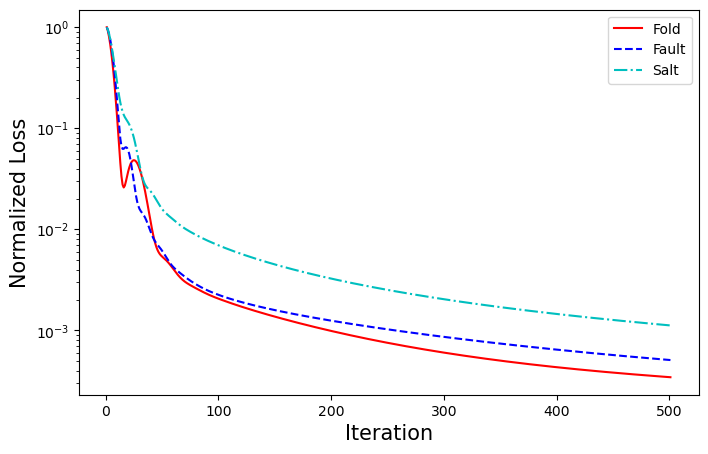

In [66]:
plt.figure(figsize=[8,5])

plt.plot(range(1,len(tomo1_norm_loss)+1),tomo1_norm_loss,'r-', label="Fold")
plt.plot(range(1,len(tomo2_norm_loss)+1),tomo2_norm_loss,'b--', label="Fault")
plt.plot(range(1,len(tomo3_norm_loss)+1),tomo3_norm_loss,'c-.', label="Salt")
#plt.title('Traveltime tomography', fontsize=15)
plt.yscale("log")
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Normalized Loss', fontsize=15)
plt.legend(loc="upper right")

plt.show()